# Kevin Egedy
## EE 560 P: Electric Machines and Drives    
## Homework 03
### Due 30 November, 2020

Copyright &copy; 2020, University of Washington

<hr>

In [1]:
# Imports
import re
import sympy as sp
import numpy as np
import pandas as pd
import control
from scipy import signal
from scipy import linalg
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option("display.max_rows", 101)
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

# Constants
Vf = 360
radsec2rpm = 30/np.pi

In [2]:
# Constants
f = 1000
Kv = 680

#### 1W Motor

In [3]:
# 1W Motor
Va1 = 170
If1 = 0.52
Rf1 = Vf/If1
Lf1 = 0.15
Ra1 = 5.59
La1 = 15.5e-3
wn1 = 1300*np.pi/30
Tr1 = 7.0
J1= 3.2e-3
b1 = 1e-4
Ke1 = Va1/wn1
Kf1 = Ke1/If1
Kt1 = Kf1*If1
K = Ke1
#TauE = La1/Ra1
#TauM = J1*Ra1/(K**2)

#### 90.8 W Motor

In [4]:
# 90.8W Motor
Va91 = 460
If91 = 3.5
Rf91 = Vf/If91
Lf91 = 0.015
Ra91 = 0.09
La91 = 1.0e-3
wn91 = 3000*np.pi/30
Tr91 = 289
J91= 0.2452
b91 = 1e-3
Ke91 = Va91/wn91
Kf91 = Ke91/If91
Kt91 = Kf91*If91
K = Ke91

#### Data Import

In [5]:
myModel = {}
myModel['perf'] = pd.read_csv('data/myModel/perf_step.csv',dtype=np.float64)
myModel['rotor'] = pd.read_csv('data/myModel/rotor_currents.csv',dtype=np.float64)
myModel['stator'] = pd.read_csv('data/myModel/stator_currents.csv',dtype=np.float64)

plecs = {}
plecs['perf'] = pd.read_csv('data/plecs/perf_step.csv',dtype=np.float64)
plecs['rotor'] = pd.read_csv('data/plecs/rotor_currents.csv',dtype=np.float64)
plecs['stator'] = pd.read_csv('data/plecs/stator_currents.csv',dtype=np.float64)

In [6]:
myModel['perf'].columns

Index(['Time', 'Rotor  Speed:Speed', '(3/2)*p*Lm', 'Step'], dtype='object')

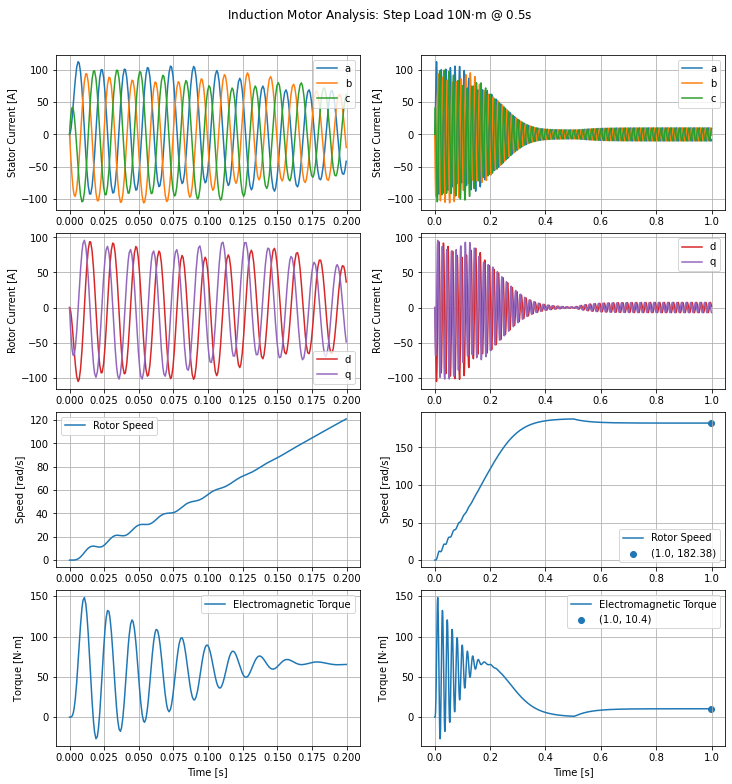

In [7]:
fig,axs = plt.subplots(4,2,figsize=(12,12))
plt.subplots_adjust(top=0.925,hspace=0.15)

df = myModel['stator'];myModel['stator'] = df[df['Time']<1]
df = myModel['rotor'];myModel['rotor'] = df[df['Time']<1]
df = myModel['perf'];myModel['perf'] = df[df['Time']<1]

labels = ['a','b','c']
for i,c in enumerate(myModel['stator'].drop('Time',axis=1).columns):
    axs[0,1].plot(myModel['stator'].Time,myModel['stator'][c],label=f'{labels[i]}')
    axs[0,1].set_ylabel('Stator Current [A]')
    axs[0,1].grid(True)
    axs[0,1].legend()

labels = ['d','q']
colors = ['tab:red','tab:purple']
for i,c in enumerate(myModel['rotor'].drop('Time',axis=1).columns):
    axs[1,1].plot(myModel['rotor'].Time,myModel['rotor'][c],color=f'{colors[i]}',label=f'{labels[i]}')
    axs[1,1].set_ylabel('Rotor Current [A]')
    axs[1,1].grid(True)
    axs[1,1].legend()

labels = ['Rotor Speed']
axs[2,1].plot(myModel['perf'].Time,myModel['perf']['Rotor  Speed:Speed'],label=f'{labels[0]}')
axs[2,1].scatter(
    myModel['perf'].Time.values[-1],
    myModel['perf']['Rotor  Speed:Speed'].values[-1],
    label=f"({round(myModel['perf'].Time.values[-1],2)}, {round(myModel['perf']['Rotor  Speed:Speed'].values[-1],2)})"
)
axs[2,1].set_ylabel('Speed [rad/s]')
axs[2,1].grid(True)
axs[2,1].legend()

labels = ['Electromagnetic Torque']
axs[3,1].plot(myModel['perf'].Time,myModel['perf']['(3/2)*p*Lm'],label=f'{labels[0]}')
axs[3,1].scatter(
    myModel['perf'].Time.values[-1],
    myModel['perf']['(3/2)*p*Lm'].values[-1],
    label=f"({round(myModel['perf'].Time.values[-1],2)}, {round(myModel['perf']['(3/2)*p*Lm'].values[-1],2)})"
)
axs[3,1].set_ylabel('Torque [N$\cdot$m]')
axs[3,1].set_xlabel('Time [s]')
axs[3,1].grid(True)
axs[3,1].legend()

df = myModel['stator'];myModel['stator'] = df[df['Time']<0.2]
df = myModel['rotor'];myModel['rotor'] = df[df['Time']<0.2]
df = myModel['perf'];myModel['perf'] = df[df['Time']<0.2]

labels = ['a','b','c']
for i,c in enumerate(myModel['stator'].drop('Time',axis=1).columns):
    axs[0,0].plot(myModel['stator'].Time,myModel['stator'][c],label=f'{labels[i]}')
    axs[0,0].set_ylabel('Stator Current [A]')
    axs[0,0].grid(True)
    axs[0,0].legend()

labels = ['d','q']
colors = ['tab:red','tab:purple']
for i,c in enumerate(myModel['rotor'].drop('Time',axis=1).columns):
    axs[1,0].plot(myModel['rotor'].Time,myModel['rotor'][c],color=f'{colors[i]}',label=f'{labels[i]}')
    axs[1,0].set_ylabel('Rotor Current [A]')
    axs[1,0].grid(True)
    axs[1,0].legend()

labels = ['Rotor Speed']
axs[2,0].plot(myModel['perf'].Time,myModel['perf']['Rotor  Speed:Speed'],label=f'{labels[0]}')
axs[2,0].set_ylabel('Speed [rad/s]')
axs[2,0].grid(True)
axs[2,0].legend()

labels = ['Electromagnetic Torque']
axs[3,0].plot(myModel['perf'].Time,myModel['perf']['(3/2)*p*Lm'],label=f'{labels[0]}')
axs[3,0].set_ylabel('Torque [N$\cdot$m]')
axs[3,0].set_xlabel('Time [s]')
axs[3,0].grid(True)
axs[3,0].legend()

plt.suptitle('Induction Motor Analysis: Step Load 10N$\cdot$m @ 0.5s')
plt.show();

In [8]:
plecs['perf'].columns

Index(['Time', 'Squirrel-Cage IM:Rotational speed',
       'Squirrel-Cage IM:Electrical torque', 'Step:Output'],
      dtype='object')

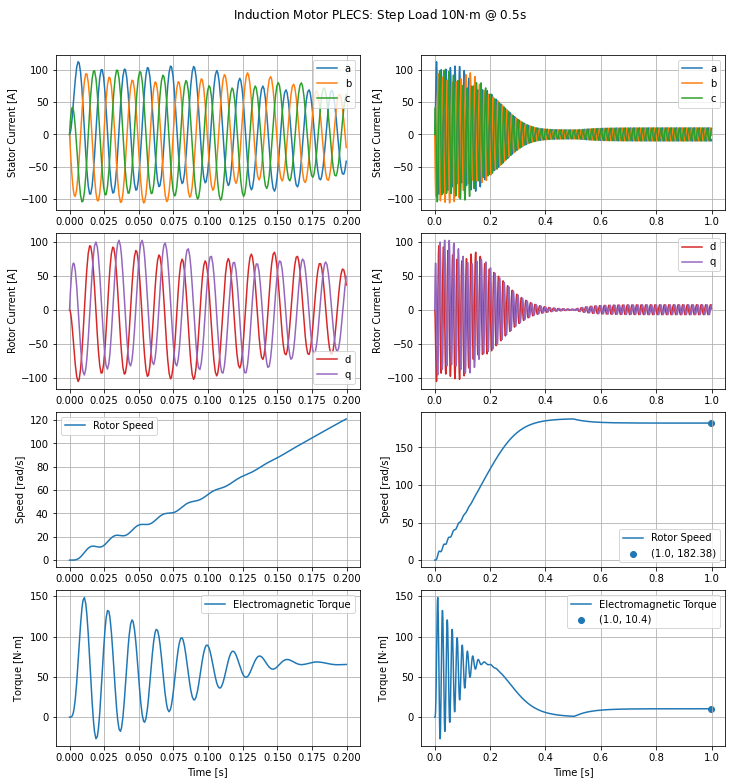

In [9]:
fig,axs = plt.subplots(4,2,figsize=(12,12))
plt.subplots_adjust(top=0.925,hspace=0.15)

df = plecs['stator'];plecs['stator'] = df[df['Time']<1]
df = plecs['rotor'];plecs['rotor'] = df[df['Time']<1]
df = plecs['perf'];plecs['perf'] = df[df['Time']<1]

labels = ['a','b','c']
for i,c in enumerate(plecs['stator'].drop('Time',axis=1).columns):
    axs[0,1].plot(plecs['stator'].Time,plecs['stator'][c],label=f'{labels[i]}')
    axs[0,1].set_ylabel('Current [A]')
    axs[0,1].set_ylabel('Stator Current [A]')
    axs[0,1].grid(True)
    axs[0,1].legend()

labels = ['d','q']
colors = ['tab:red','tab:purple']
for i,c in enumerate(plecs['rotor'].drop('Time',axis=1).columns):
    axs[1,1].plot(plecs['rotor'].Time,plecs['rotor'][c],color=f'{colors[i]}',label=f'{labels[i]}')
    axs[1,1].set_ylabel('Current [A]')
    axs[1,1].set_ylabel('Rotor Current [A]')
    axs[1,1].grid(True)
    axs[1,1].legend()

labels = ['Rotor Speed']
axs[2,1].plot(plecs['perf'].Time,plecs['perf']['Squirrel-Cage IM:Rotational speed'],label=f'{labels[0]}')
axs[2,1].scatter(
    plecs['perf'].Time.values[-1],
    plecs['perf']['Squirrel-Cage IM:Rotational speed'].values[-1],
    label=f"({round(plecs['perf'].Time.values[-1],2)}, {round(plecs['perf']['Squirrel-Cage IM:Rotational speed'].values[-1],2)})"
)
axs[2,1].set_ylabel('Speed [rad/s]')
axs[2,1].grid(True)
axs[2,1].legend()

labels = ['Electromagnetic Torque']
axs[3,1].plot(plecs['perf'].Time,plecs['perf']['Squirrel-Cage IM:Electrical torque'],label=f'{labels[0]}')
axs[3,1].scatter(
    plecs['perf'].Time.values[-1],
    plecs['perf']['Squirrel-Cage IM:Electrical torque'].values[-1],
    label=f"({round(plecs['perf'].Time.values[-1],2)}, {round(plecs['perf']['Squirrel-Cage IM:Electrical torque'].values[-1],2)})"
)
axs[3,1].set_ylabel('Torque [N$\cdot$m]')
axs[3,1].set_xlabel('Time [s]')
axs[3,1].grid(True)
axs[3,1].legend()

df = plecs['stator'];plecs['stator'] = df[df['Time']<0.2]
df = plecs['rotor'];plecs['rotor'] = df[df['Time']<0.2]
df = plecs['perf'];plecs['perf'] = df[df['Time']<0.2]

labels = ['a','b','c']
for i,c in enumerate(plecs['stator'].drop('Time',axis=1).columns):
    axs[0,0].plot(plecs['stator'].Time,plecs['stator'][c],label=f'{labels[i]}')
    axs[0,0].set_ylabel('Stator Current [A]')
    axs[0,0].grid(True)
    axs[0,0].legend()

labels = ['d','q']
colors = ['tab:red','tab:purple']
for i,c in enumerate(plecs['rotor'].drop('Time',axis=1).columns):
    axs[1,0].plot(plecs['rotor'].Time,plecs['rotor'][c],color=f'{colors[i]}',label=f'{labels[i]}')
    axs[1,0].set_ylabel('Rotor Current [A]')
    axs[1,0].grid(True)
    axs[1,0].legend()

labels = ['Rotor Speed']
axs[2,0].plot(plecs['perf'].Time,plecs['perf']['Squirrel-Cage IM:Rotational speed'],label=f'{labels[0]}')
axs[2,0].set_ylabel('Speed [rad/s]')
axs[2,0].grid(True)
axs[2,0].legend()

labels = ['Electromagnetic Torque']
axs[3,0].plot(plecs['perf'].Time,plecs['perf']['Squirrel-Cage IM:Electrical torque'],label=f'{labels[0]}')
axs[3,0].set_ylabel('Torque [N$\cdot$m]')
axs[3,0].set_xlabel('Time [s]')
axs[3,0].grid(True)
axs[3,0].legend()

plt.suptitle('Induction Motor PLECS: Step Load 10N$\cdot$m @ 0.5s')
plt.show();

In [10]:
myModel = {}
myModel['perf'] = pd.read_csv('data/myModel/perf_step.csv',dtype=np.float64)
myModel['rotor'] = pd.read_csv('data/myModel/rotor_currents.csv',dtype=np.float64)
myModel['stator'] = pd.read_csv('data/myModel/stator_currents.csv',dtype=np.float64)

plecs = {}
plecs['perf'] = pd.read_csv('data/plecs/perf_step.csv',dtype=np.float64)
plecs['rotor'] = pd.read_csv('data/plecs/rotor_currents.csv',dtype=np.float64)
plecs['stator'] = pd.read_csv('data/plecs/stator_currents.csv',dtype=np.float64)

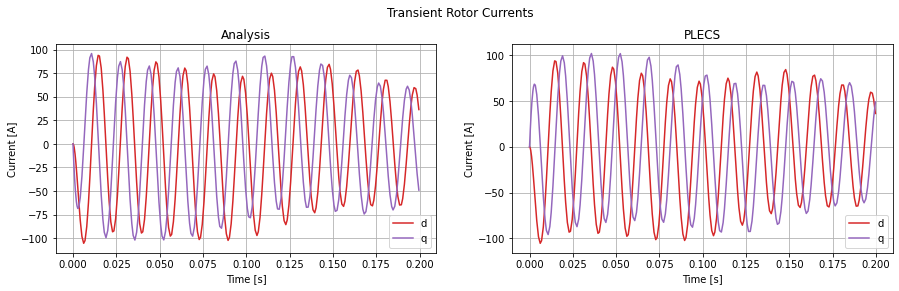

In [11]:
fig,axs = plt.subplots(1,2,figsize=(15,4))
plt.subplots_adjust(top=0.85,hspace=0.15)

df = myModel['stator'];myModel['stator'] = df[df['Time']<0.2]
df = myModel['rotor'];myModel['rotor'] = df[df['Time']<0.2]
df = myModel['perf'];myModel['perf'] = df[df['Time']<0.2]

df = plecs['stator'];plecs['stator'] = df[df['Time']<0.2]
df = plecs['rotor'];plecs['rotor'] = df[df['Time']<0.2]
df = plecs['perf'];plecs['perf'] = df[df['Time']<0.2]

# MYMODEL
labels = ['d','q']
colors = ['tab:red','tab:purple']
for i,c in enumerate(myModel['rotor'].drop('Time',axis=1).columns):
    axs[0].plot(myModel['rotor'].Time,myModel['rotor'][c],color=f'{colors[i]}',label=f'{labels[i]}')
    axs[0].set_ylabel('Current [A]')
    axs[0].set_xlabel('Time [s]')
    axs[0].grid(True)
    axs[0].set_title('Analysis')
    axs[0].legend(loc='lower right')

# PLECS
labels = ['d','q']
colors = ['tab:red','tab:purple']
for i,c in enumerate(plecs['rotor'].drop('Time',axis=1).columns):
    axs[1].plot(plecs['rotor'].Time,plecs['rotor'][c],color=f'{colors[i]}',label=f'{labels[i]}')
    axs[1].set_ylabel('Current [A]')
    axs[1].set_xlabel('Time [s]')
    axs[1].grid(True)
    axs[1].set_title('PLECS')
    axs[1].legend(loc='lower right')

plt.suptitle('Transient Rotor Currents')
plt.show();